In [1]:
import os
import random
from glob import glob
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from PIL import Image
from sklearn import decomposition
from torch.utils.data import DataLoader, Dataset
from torchvision import io
from torchvision.transforms.v2 import functional as F
from transformers import AutoImageProcessor, AutoModel

## Data Exploration:

In [2]:
# Set images path
train_images_path = Path("../data/BrainTumor/train/images")
test_images_path = Path("../data/BrainTumor/test/images")
valid_images_path = Path("../data/BrainTumor/valid/images")

# Set labels path
train_labels_path = Path("../data/BrainTumor/train/labels")
test_labels_path = Path("../data/BrainTumor/test/labels")
valid_labels_path = Path("../data/BrainTumor/valid/labels")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]

# Define datasets
datasets = [
    (train_images_path, train_labels_path, "Train"),
    (test_images_path, test_labels_path, "Test"),
    (valid_images_path, valid_labels_path, "Validation"),
]

In [3]:
# Analyze directories
def analyze_dataset_directory(directory: Path, file_type: str = "image") -> None:
    if file_type == "image":
        files = list(directory.glob("*.jpg")) + list(directory.glob("*.png"))
        image_sizes = []
        for file in files:
            with Image.open(file) as img:
                image_sizes.append(img.size)
        print(f"Images in {directory.name}: {len(files)}, Different sizes: {set(image_sizes)}")

    elif file_type == "label":
        files = list(directory.glob("*.txt"))
        labels_per_file = []
        for file in files:
            with open(file, "r") as f:
                labels = f.readlines()
            labels_per_file.append(len(labels))
        print(f"Labels in {directory.name}: {len(files)}, Labels per file: {set(labels_per_file)}")


for images_path, labels_path, dataset_name in datasets:
    print(f"\n{dataset_name} Dataset:")
    analyze_dataset_directory(images_path, "image")
    analyze_dataset_directory(labels_path, "label")


Train Dataset:
Images in images: 2144, Different sizes: {(640, 640)}
Labels in labels: 2144, Labels per file: {1}

Test Dataset:
Images in images: 308, Different sizes: {(640, 640)}
Labels in labels: 308, Labels per file: {1}

Validation Dataset:
Images in images: 612, Different sizes: {(640, 640)}
Labels in labels: 612, Labels per file: {1}


In [4]:
# Check that all images are labeled
def image_has_label(images_path: Path, labels_path: Path) -> None:
    for image_path in images_path.glob("*.jpg"):
        label_file = labels_path / f"{image_path.stem}.txt"
        if not label_file.exists():
            print(f"Image {image_path} does not have a corresponding label file.")
    print(f"All images in {images_path} have corresponding label files in {labels_path}")


for images_path, labels_path, dataset_name in datasets:
    print(f"\n{dataset_name} Dataset:")
    image_has_label(images_path, labels_path)


Train Dataset:
All images in ../data/BrainTumor/train/images have corresponding label files in ../data/BrainTumor/train/labels

Test Dataset:
All images in ../data/BrainTumor/test/images have corresponding label files in ../data/BrainTumor/test/labels

Validation Dataset:
All images in ../data/BrainTumor/valid/images have corresponding label files in ../data/BrainTumor/valid/labels


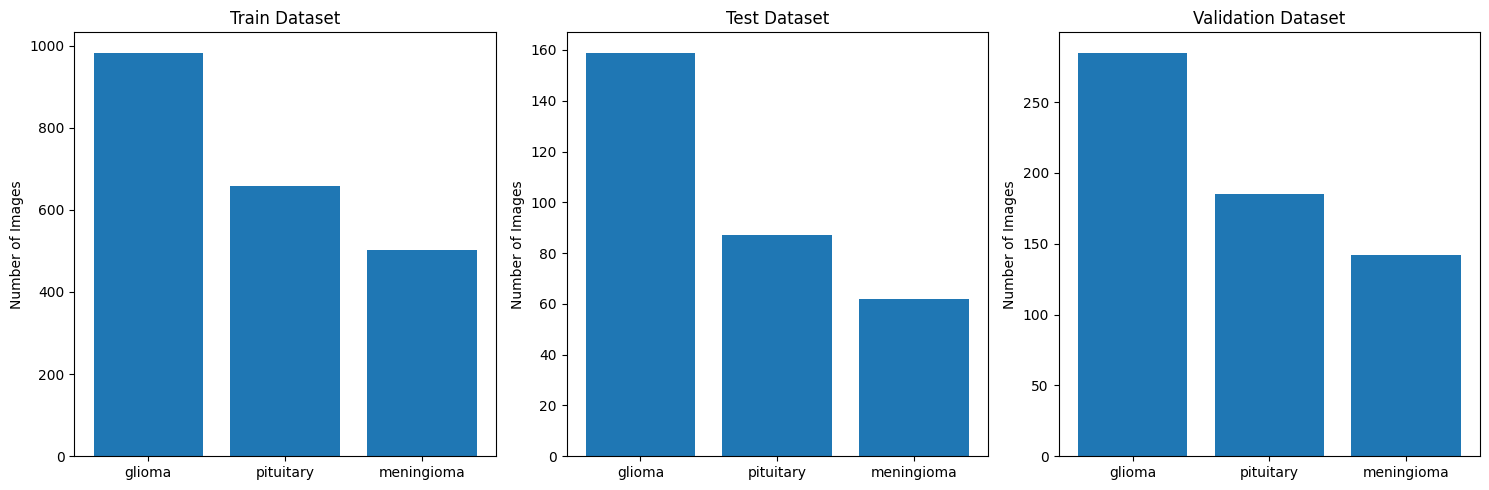

In [5]:
# Explore classes and coordinates
def get_image_label_info(label_file: Path) -> Tuple[str, List[float]]:
    with open(label_file, "r") as f:
        lines = f.readlines()[0]
        entries = lines.strip().split()
    # Extract class id (first entry)
    class_id = int(entries[0])
    class_name = CLASSES_NAMES[class_id]

    # Coordinates are in pairs: x1, y1, x2, y2, ..., xn, yn
    coordinates = [float(i) for i in entries[1:]]
    x_coords = coordinates[::2]
    y_coords = coordinates[1::2]
    polygon_coordinates = list(zip(x_coords, y_coords))

    # Get bounding box from polygon
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Convert to center format
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    bw = x_max - x_min
    bh = y_max - y_min

    bbox = [cx, cy, bw, bh]

    return class_name, bbox, polygon_coordinates


def explore_classes_and_polygon_coordinates(labels_path: Path) -> Tuple[Dict[str, str], Dict[str, List[float]]]:
    classes = {}
    coordinates = {}
    for label_file in labels_path.glob("*.txt"):
        image_class_name, bboxes, polygon_coordinates = get_image_label_info(label_file)
        classes[label_file.stem] = image_class_name
        coordinates[label_file.stem] = polygon_coordinates

    return classes, coordinates


# Plot all three class distributions
def plot_class_distribution(train_classes: dict, test_classes: dict, valid_classes: dict) -> None:
    plt.figure(figsize=(15, 5))

    dataset_names = ["Train", "Test", "Validation"]

    for i, dct in enumerate([train_classes, test_classes, valid_classes]):
        class_counts = {}
        for class_name in dct.values():
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        # Order classes by frequency
        class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

        plt.subplot(1, 3, i + 1)
        plt.bar(class_counts.keys(), class_counts.values())
        plt.ylabel("Number of Images")
        plt.title(f"{dataset_names[i]} Dataset")

    plt.tight_layout()
    plt.show()


train_classes, train_coordinates = explore_classes_and_polygon_coordinates(train_labels_path)
test_classes, test_coordinates = explore_classes_and_polygon_coordinates(test_labels_path)
valid_classes, valid_coordinates = explore_classes_and_polygon_coordinates(valid_labels_path)
plot_class_distribution(train_classes, test_classes, valid_classes)

Image: 1501_jpg.rf.08e32a7d2de025dc02a912835d43c94e
Class: pituitary
Image size: 640 x 640
Number of polygon vertices: 17
Raw coordinates (first 10): [(0.49303621093750005, 0.5933147625), (0.5320334265625, 0.5849582171875001), (0.5543175484375, 0.5069637890625), (0.5348189421875, 0.46239554375), (0.5013927578125, 0.42339832812499995), (0.43454039062499994, 0.4150417828125), (0.4150417828125, 0.43175487500000004), (0.3704735375, 0.428969359375), (0.3454039, 0.4428969359375), (0.317548746875, 0.484679665625)]
Bounding Box (pixels): x=199.7, y=265.6, w=155.1, h=124.8


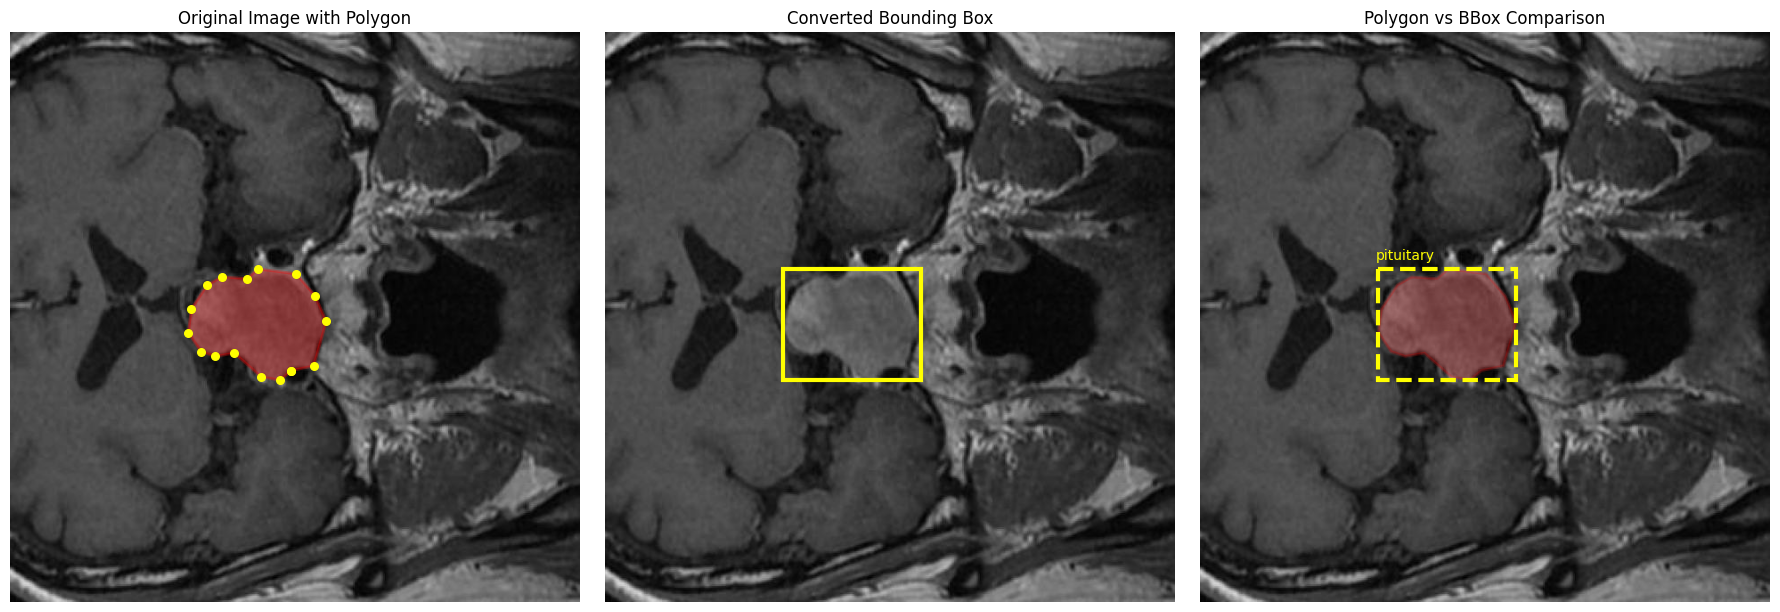

In [6]:
def visualize_polygon_vs_bbox(image_name: str) -> None:
    # Load image and label
    image = io.read_image(f"../data/BrainTumor/train/images/{image_name}.jpg")
    label_file = f"../data/BrainTumor/train/labels/{image_name}.txt"

    class_name, bbox, coordinates = get_image_label_info(label_file)
    h, w = F.get_size(image)

    print(f"Image: {image_name}")
    print(f"Class: {class_name}")
    print(f"Image size: {w} x {h}")
    print(f"Number of polygon vertices: {len(coordinates)}")
    print(f"Raw coordinates (first 10): {coordinates[:10]}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original image with polygon overlay
    ax1 = axes[0]
    ax1.imshow(image.permute(1, 2, 0).numpy())
    ax1.set_title("Original Image with Polygon")

    # Scale coordinates to image size
    x_coords = [vertice[0] * w for vertice in coordinates]
    y_coords = [vertice[1] * h for vertice in coordinates]

    # Create polygon patch
    polygon_points = list(zip(x_coords, y_coords))
    polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.3, closed=True)
    ax1.add_patch(polygon)

    # Mark vertices
    ax1.scatter(x_coords, y_coords, color="yellow", s=30, zorder=5)
    ax1.axis("off")

    # 2. Converted bounding box
    ax2 = axes[1]
    ax2.imshow(image.permute(1, 2, 0).numpy())
    ax2.set_title("Converted Bounding Box")

    # Scale to image size
    cx, cy, bw, bh = bbox
    cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

    # Convert to corner format for visualization
    x_min_scaled = cx - bw / 2
    y_min_scaled = cy - bh / 2

    # Draw bounding box
    rect = patches.Rectangle((x_min_scaled, y_min_scaled), bw, bh, linewidth=3, edgecolor="yellow", facecolor="none")
    ax2.add_patch(rect)

    print(f"Bounding Box (pixels): x={x_min_scaled:.1f}, y={y_min_scaled:.1f}, w={bw:.1f}, h={bh:.1f}")

    ax2.axis("off")

    # 3. Comparison overlay
    ax3 = axes[2]
    ax3.imshow(image.permute(1, 2, 0).numpy())
    ax3.set_title("Polygon vs BBox Comparison")

    # Draw both polygon and bounding box
    polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True)
    ax3.add_patch(polygon)

    # Add class name tag to bounding box
    ax3.text(x_min_scaled + 30, y_min_scaled - 10, class_name, color="yellow", fontsize=10, ha="center")

    rect = patches.Rectangle(
        (x_min_scaled, y_min_scaled),
        bw,
        bh,
        linewidth=3,
        edgecolor="yellow",
        facecolor="none",
        linestyle="--",
    )
    ax3.add_patch(rect)
    ax3.axis("off")

    plt.tight_layout()
    plt.show()


# Run the visualization
train_images = list(train_images_path.glob("*.jpg"))
sample = random.choice(train_images)
image_name = sample.stem

visualize_polygon_vs_bbox(image_name)

## Model Summary:

In [7]:
# Load Dinov2 model and transformer
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

torchinfo.summary(
    dinov2,
    input_data=torch.randn(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,
    row_settings=["var_names"],
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
Dinov2Model (Dinov2Model)                                    [1, 3, 224, 224]          [1, 768]                  --                        True
├─Dinov2Embeddings (embeddings)                              [1, 3, 224, 224]          [1, 257, 768]             1,053,696                 True
│    └─Dinov2PatchEmbeddings (patch_embeddings)              [1, 3, 224, 224]          [1, 256, 768]             --                        True
│    │    └─Conv2d (projection)                              [1, 3, 224, 224]          [1, 768, 16, 16]          452,352                   True
│    └─Dropout (dropout)                                     [1, 257, 768]             [1, 257, 768]             --                        --
├─Dinov2Encoder (encoder)                                    [1, 257, 768]             [1, 257, 768]             --                  

## Feature Extraction Visualization:

In [8]:
# Set random seed
random.seed(5)

# Number of images to select
num_images = 5

# Get n random image paths
img_dir = "../data/BrainTumor/train/images"
img_paths = glob(os.path.join(img_dir, "*.jpg"))
selected_imgs = random.sample(img_paths, num_images)

# Load images
images = [Image.open(p) for p in selected_imgs]

# Preprocess images
inputs = processor(images=images, return_tensors="pt")

# Extract patch embeddings for all images
dinov2.eval()
with torch.no_grad():
    outputs = dinov2(**inputs)
    feature_maps = outputs.last_hidden_state[:, 1:, :]

# Stack all patches from all images
batch_size, num_patches, embed_dim = feature_maps.shape
all_patches = feature_maps.reshape(-1, embed_dim)

print(f"Feature maps shape: {feature_maps.shape} [batch_size, num_patches, embed_dim]")
print(f"All patches shape: {all_patches.shape} [batch_size*num_patches, embed_dim]")

Feature maps shape: torch.Size([5, 256, 768]) [batch_size, num_patches, embed_dim]
All patches shape: torch.Size([1280, 768]) [batch_size*num_patches, embed_dim]


PCA explained variance ratio: [0.11963072 0.09923572 0.08758808]
Total variance explained: 0.306


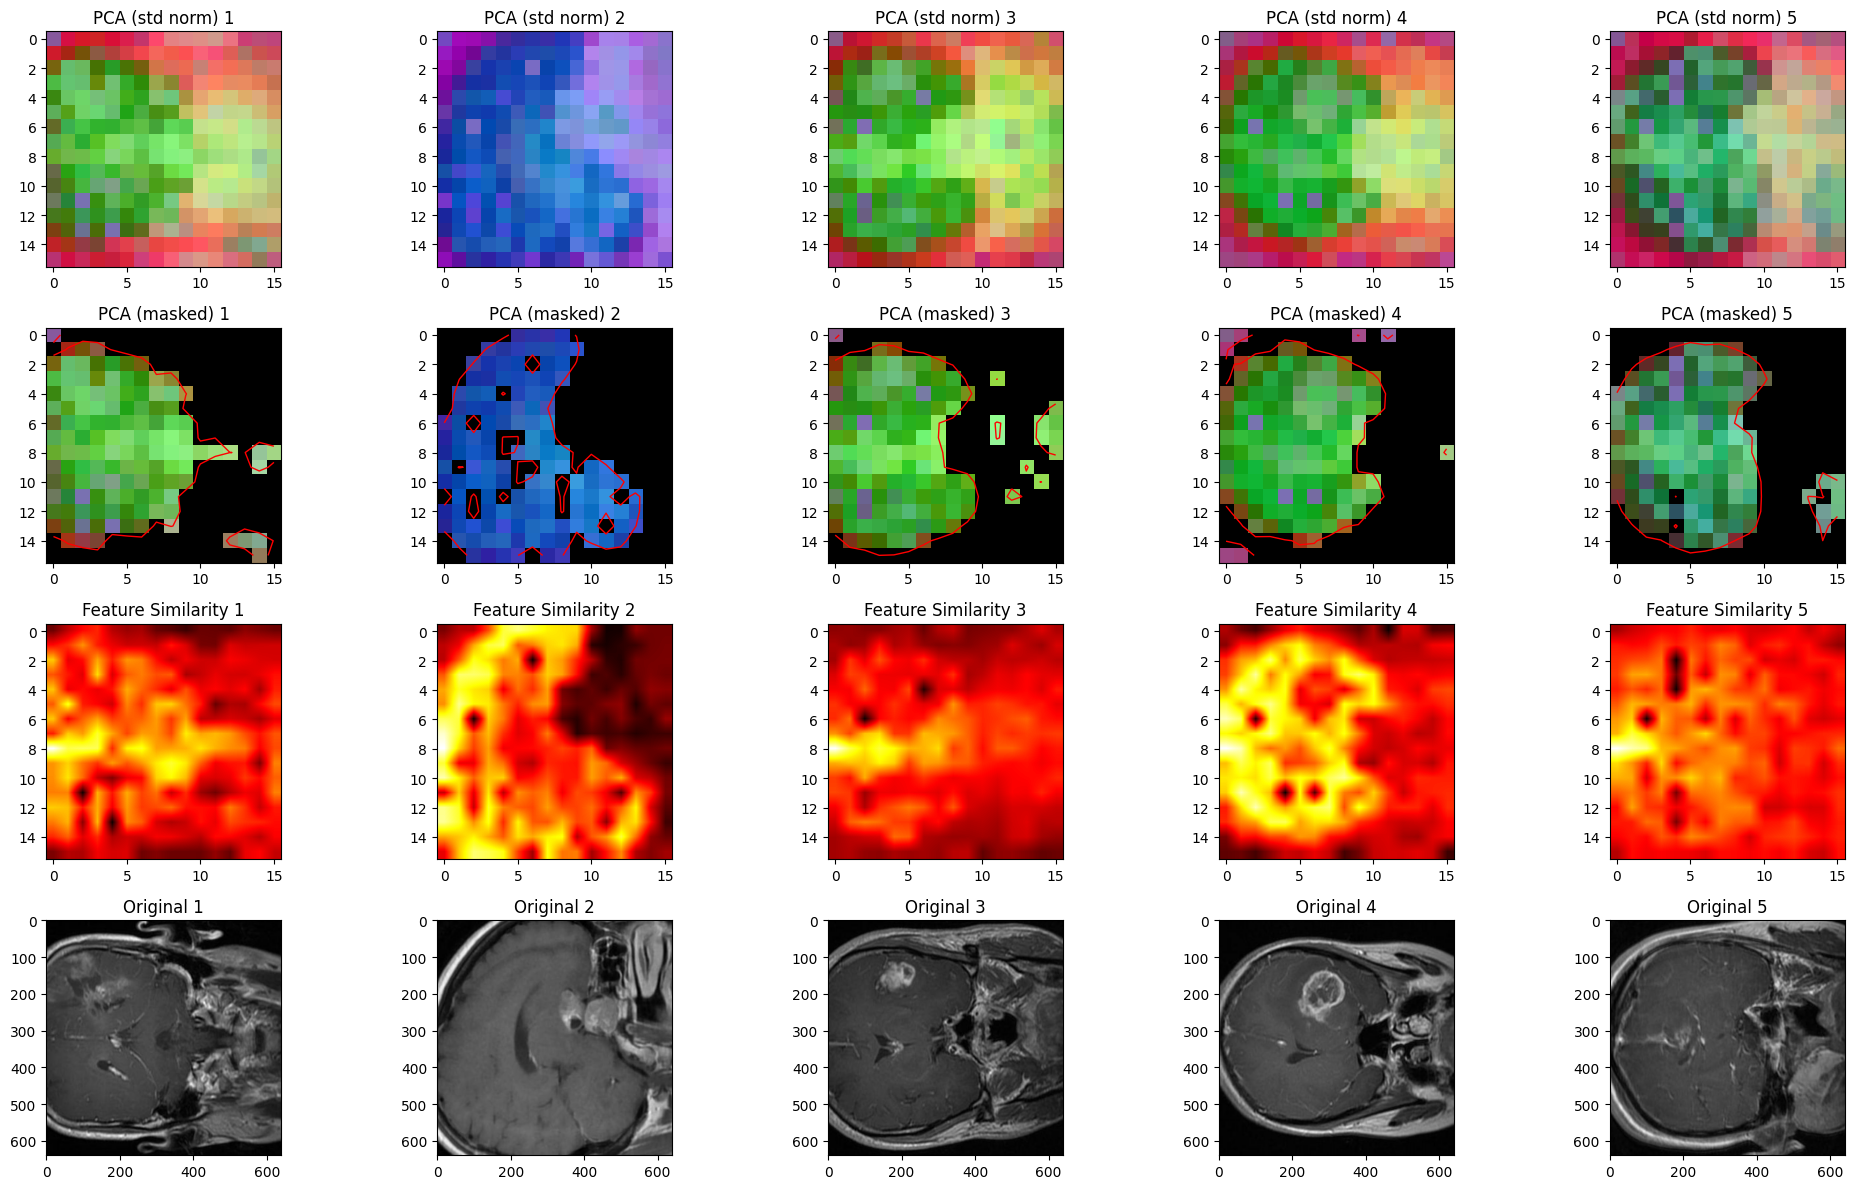

In [9]:
# Apply PCA to all patches
pca = decomposition.PCA(n_components=3)
all_pca = pca.fit_transform(all_patches)

# PCA variance
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Standardize PCA results and normalize to [0, 1]
all_pca_std = (all_pca - all_pca.mean(0)) / (all_pca.std(0) + 1e-8)
all_pca_std_norm = (all_pca_std - all_pca_std.min(0)) / (np.ptp(all_pca_std, axis=0) + 1e-8)

# Split back to images with improved normalization
num_patches_side = int(np.sqrt(num_patches))
pca_imgs_std = all_pca_std_norm.reshape(batch_size, num_patches, 3)
pca_imgs_std = pca_imgs_std.reshape(batch_size, num_patches_side, num_patches_side, 3)

# Apply adaptive background masking based on the first principal component
fig, axs = plt.subplots(4, batch_size, figsize=(4 * batch_size, 12))

for i in range(batch_size):
    # Compute adaptive threshold for background masking
    first_pc = pca_imgs_std[i][..., 0]
    threshold = np.percentile(first_pc, 50)  # Use 50th percentile as threshold

    # Apply background mask
    background_mask = first_pc > threshold
    pca_img_masked = pca_imgs_std[i].copy()
    pca_img_masked[background_mask] = 0

    # Compute cosine similarity between patch features
    image_patches = feature_maps[i]  # [num_patches, embed_dim]
    patches_norm = torch.nn.functional.normalize(image_patches, p=2, dim=1)
    similarity_matrix = torch.mm(patches_norm, patches_norm.T)

    # Use center patch as reference
    center_idx = similarity_matrix.shape[0] // 2
    center_similarities = similarity_matrix[center_idx, :]
    similarity_map = center_similarities.reshape(num_patches_side, num_patches_side)

    # Original PCA (no masking)
    axs[0, i].imshow(pca_imgs_std[i])
    axs[0, i].set_title(f"PCA (std norm) {i + 1}")

    # PCA with adaptive background masking
    axs[1, i].imshow(pca_img_masked)
    axs[1, i].set_title(f"PCA (masked) {i + 1}")
    axs[1, i].contour(first_pc, levels=[threshold], colors="red", linewidths=1)

    # Feature similarity
    axs[2, i].imshow(similarity_map.cpu().numpy(), cmap="hot", interpolation="bilinear")
    axs[2, i].set_title(f"Feature Similarity {i + 1}")

    # Original image
    axs[3, i].imshow(images[i])
    axs[3, i].set_title(f"Original {i + 1}")

plt.tight_layout()
plt.show()

## Set up dataset

In [10]:
class CustomDataset(Dataset):
    """Simplified Dataset for object detection"""

    def __init__(self, directory: Path, processor=None) -> None:
        """
        Args:
            directory: Path to images and labels folder
            processor: Image processor (DINOv2 processor)
        """
        super().__init__()
        self.images_dir = directory / "images"
        self.labels_dir = directory / "labels"
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_labels(label_path, image.size)

        # Process image
        if self.processor:
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image["pixel_values"].squeeze(0)
        else:
            pixel_values = image

        return {"pixel_values": pixel_values, "labels": labels, "image_path": str(img_path), "original_image": image}

    def _load_labels(self, label_path: Path, image_size: Tuple[int, int]) -> List[Dict[str, Any]]:
        """Load labels from text file"""
        labels = []
        img_width, img_height = image_size

        with open(label_path, "r") as f:
            line = f.readlines()[0]
            entries = line.strip().split()

        # Extract class id (first entry)
        class_id = int(entries[0])

        # Extract polygon coordinates
        coordinates = [float(i) for i in entries[1:]]
        x_coords = [i * img_width for i in coordinates[::2]]
        y_coords = [i * img_height for i in coordinates[1::2]]

        # Get bounding box from polygon vertices
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        labels.append(
            {"class_id": class_id, "bbox": [x_min, y_min, x_max, y_max], "vertices": list(zip(x_coords, y_coords))}
        )

        return labels

## Setup Dataloaders:

In [11]:
def create_dataloaders(
    train_dir: Path, test_dir: Path, processor, batch_size: int = 16
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = CustomDataset(train_dir, processor)
    test_dataset = CustomDataset(test_dir, processor)

    def collate_fn(batch) -> Dict[str, Any]:
        """Custom collate function to handle variable number of labels"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = [item["labels"] for item in batch]
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader

In [12]:
train_dir = Path("../data/BrainTumor/train")
test_dir = Path("../data/BrainTumor/test")

# Create train and test dataloaders
train_dataloader, test_dataloader = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    processor=processor,
    batch_size=16,
)

print(f"Train dataloader: {len(train_dataloader)} batches")
print(f"Test dataloader: {len(test_dataloader)} batches")

# Visualize first train batch
for batch in train_dataloader:
    print(f"\nBatch pixel_values shape: {batch['pixel_values'].shape}")
    print(f"Batch labels: {batch['labels']}")
    break

# Print some statistics
print("\nDataset Statistics:")
total_images = 0
total_objects = 0
class_counts = {}

for batch in train_dataloader:
    labels_list = batch["labels"]
    total_images += len(labels_list)

    for labels in labels_list:
        total_objects += len(labels)
        for label in labels:
            class_id = label["class_id"]
            class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(f"Total training images: {total_images}")
print(f"Total objects: {total_objects}")
print(f"Average objects per image: {total_objects / total_images:.2f}")
print(f"Class distribution: {class_counts}")

# Test a single sample to see the data structure
print("\nSample data structure:")
sample = next(iter(train_dataloader))
print(f"Keys: {sample.keys()}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Labels for first image: {sample['labels'][0]}")

Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Train dataloader: 134 batches
Test dataloader: 20 batches

Batch pixel_values shape: torch.Size([16, 3, 224, 224])
Batch labels: [[{'class_id': 1, 'bbox': [57.047354, 331.587744, 201.448468, 452.81337], 'vertices': [(180.05571, 347.632312), (153.314763, 333.37047400000006), (128.356546, 331.587744), (99.83286899999999, 336.935933), (69.526462, 358.32869099999994), (57.047354, 376.155989), (62.395543, 418.941504), (87.35376, 447.465181), (103.39832900000002, 452.81337), (146.183844, 449.247911), (171.142061, 438.55153200000007), (201.448468, 399.33147599999995), (197.883008, 370.80779899999993), (180.05571, 347.632312)]}], [{'class_id': 2, 'bbox': [342.284123, 180.05571, 379.721448, 247.799443], 'vertices': [(379.721448, 208.579387), (347.632312, 180.05571), (342.284123, 237.10306400000002), (369.02507, 247.799443), (379.721448, 208.579387)]}], [{'class_id': 2, 'bbox': [206.796657, 28

Testing DataLoader...
Batch shape: torch.Size([16, 3, 224, 224])
Original images shape: [640, 640]
Number of images with labels: 16


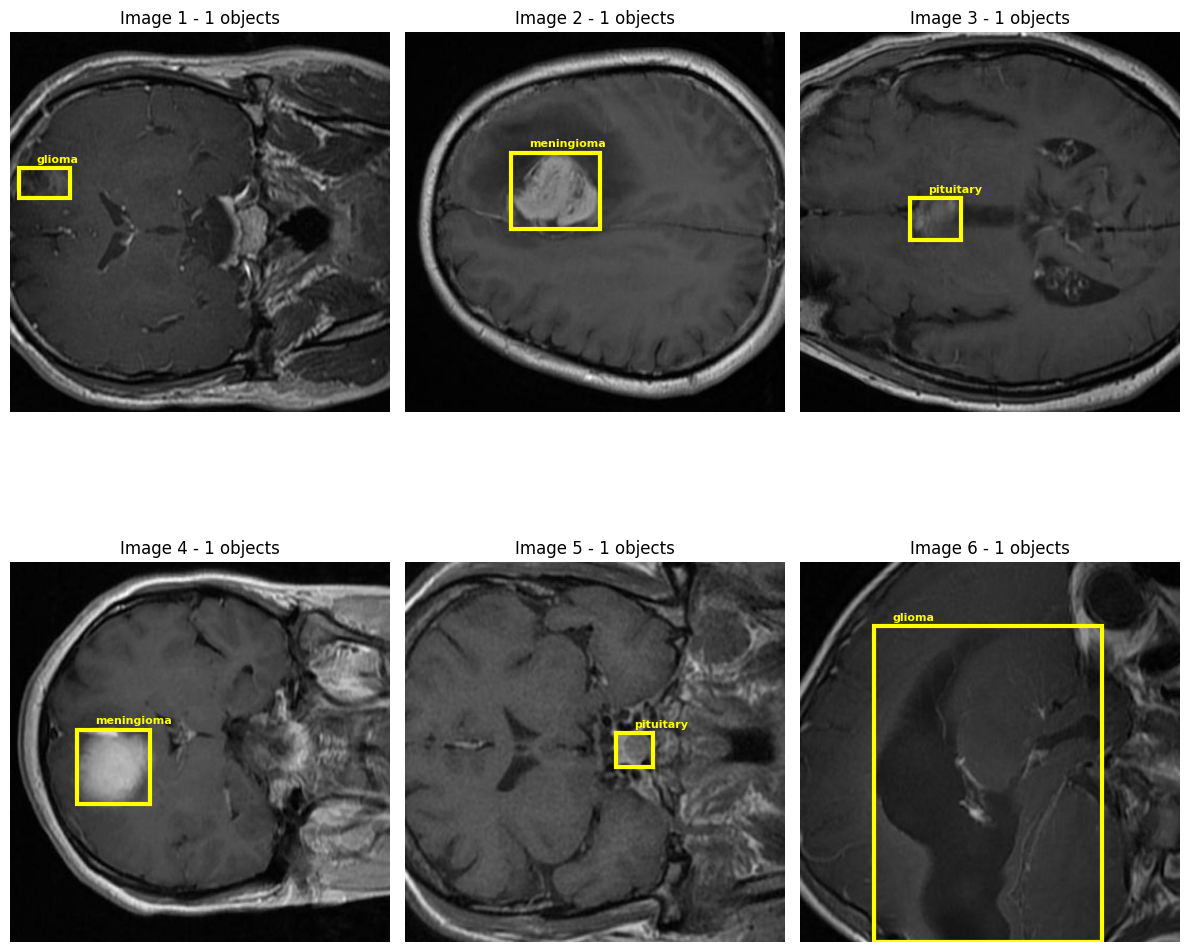

In [13]:
def visualize_batch(dataloader, num_samples=6) -> None:
    """Visualize a batch of images with YOLO bounding boxes"""

    # Get one batch
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"]
    labels_list = batch["labels"]
    original_images = batch["original_images"]

    print(f"Batch shape: {pixel_values.shape}")
    print(f"Original images shape: {F.get_size(original_images[0])}")
    print(f"Number of images with labels: {sum(1 for labels in labels_list if len(labels) > 0)}")

    # Plot images with bounding boxes
    fig, axes = plt.subplots(2, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(min(num_samples, len(original_images))):
        ax = axes[i]
        image = original_images[i]
        labels = labels_list[i]

        # Display image
        ax.imshow(image)
        ax.set_title(f"Image {i + 1} - {len(labels)} objects")
        ax.axis("off")

        # Draw bounding boxes
        for label in labels:
            bbox = label["bbox"]  # [x_min, y_min, x_max, y_max]
            class_id = label["class_id"]

            # Create rectangle patch
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=3, edgecolor="yellow", facecolor="none")
            ax.add_patch(rect)

            # Add class label
            ax.text(x_min + 30, y_min - 10, f"{CLASSES_NAMES[class_id]}", color="yellow", fontsize=8, fontweight="bold")

    plt.tight_layout()
    plt.show()


# Test the dataloader
print("Testing DataLoader...")
visualize_batch(train_dataloader)